# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
sys.path.append('./../..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator

import math

# Simulator

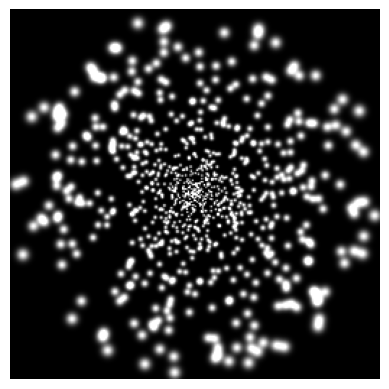

In [2]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda().detach() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

Loss = 0.0272:   0%|                                                                                                                                                                                                                      | 0/2000 [00:00<?, ?iter/s]

Loss = 0.0025: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.28iter/s]


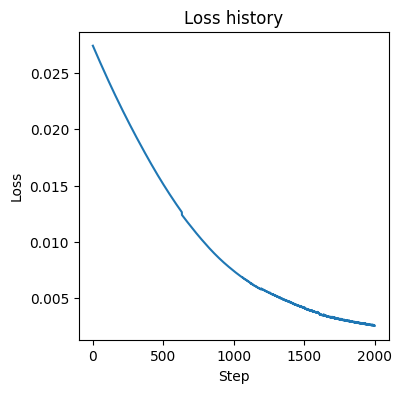

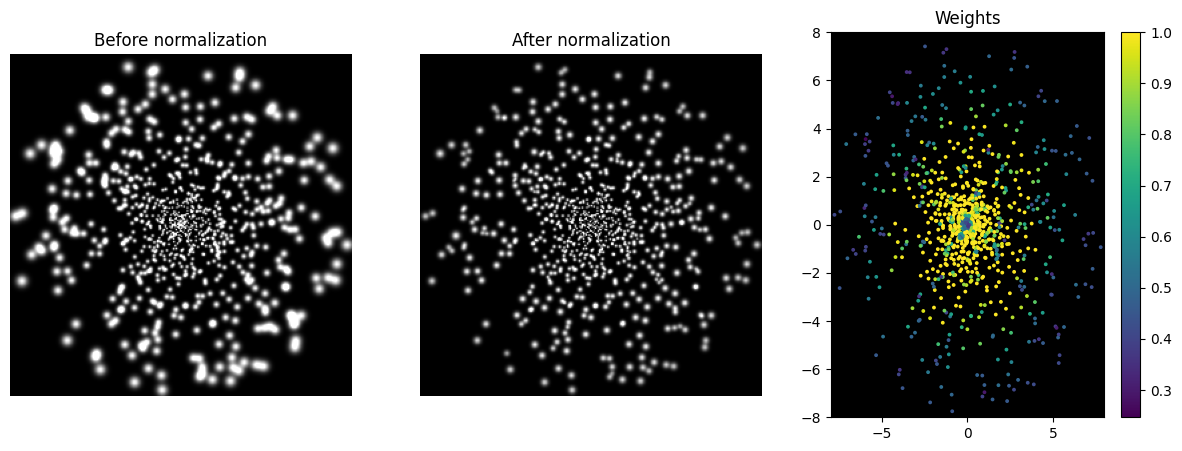

Percentage of amplitude: 77.10%


In [3]:
from phosphene.uniformity import DynamicAmplitudeNormalizer

stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=3,
    scale=0.0001,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.002,
    steps=2000,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init, verbose=True)
stim_weights = normalizer.weights

# plot the loss_history from the normalizer
plt.figure(figsize=(4, 4))
plt.plot(normalizer.loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu(), cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu(), cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# extend the axes to the full image size
fov = simulator.params['run']['view_angle']
plt.xlim(-fov/2, fov/2)
plt.ylim(-fov/2, fov/2)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# percentage of amplitude compared to full amplitude
print(f'Percentage of amplitude: {stim_weights.sum() / simulator.num_phosphenes*100:.2f}%')

# Phosphene Density Maps

In [4]:
from phosphene.density import VisualFieldMapper

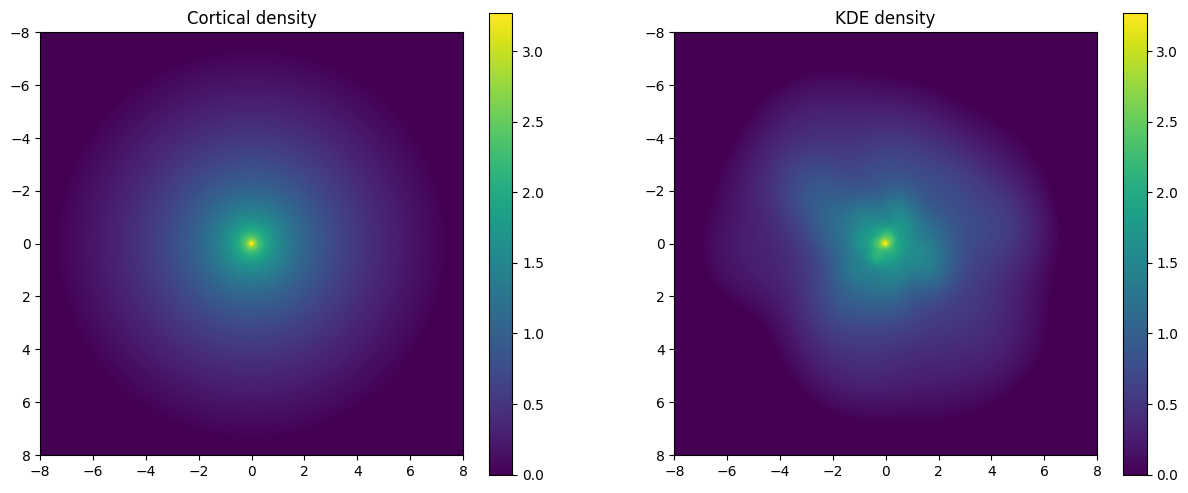

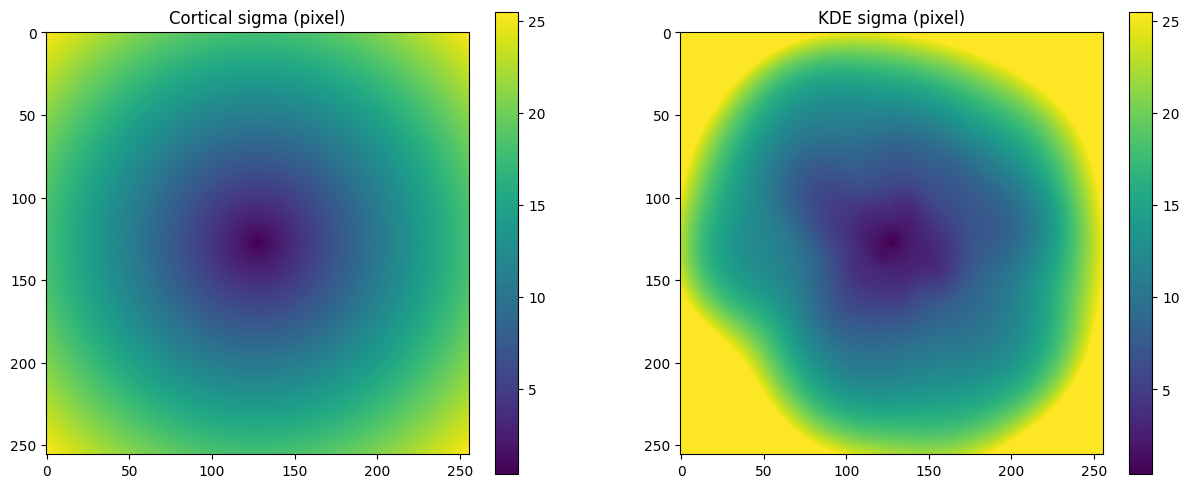

In [5]:
mapper = VisualFieldMapper(simulator=simulator)

# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=16, alpha=1.0, total_phosphenes=1024)
sigma_kde_fov = mapper.build_sigma_map_from_density(density_kde, space="fov")
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

# show density maps
fov = params['run']['view_angle']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(density_cortical), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmin=0)
plt.colorbar()
plt.title('Cortical density')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(density_kde), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmax=np.log10(density_cortical.max()), vmin=0)
plt.colorbar()
plt.title('KDE density')
plt.show()

# plot sigma_cortical_pix, sigma_kde_pix
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

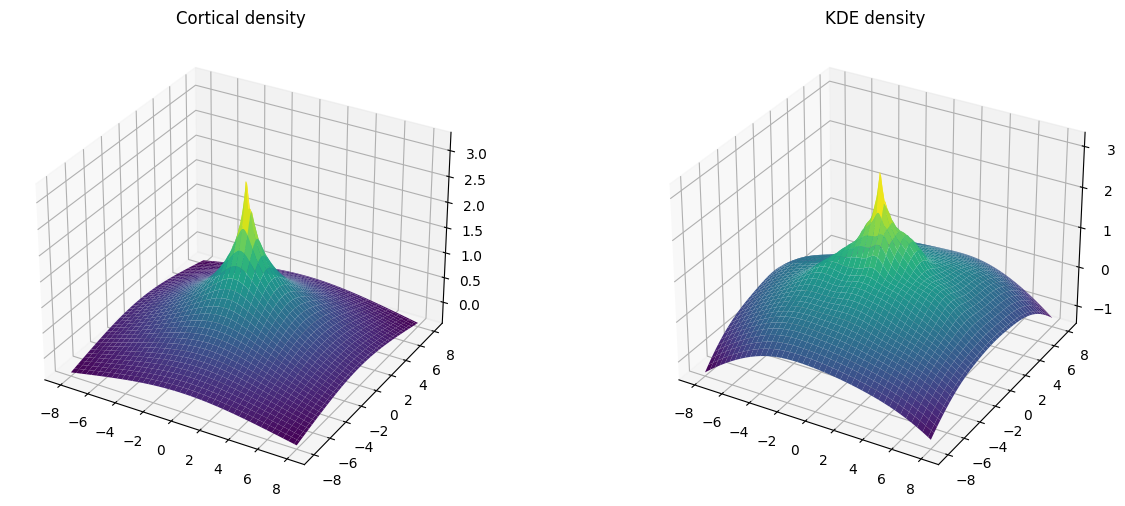

In [6]:
# 3d plot of the cortical density maps
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(np.linspace(-fov/2, fov/2, density_cortical.shape[1]), np.linspace(-fov/2, fov/2, density_cortical.shape[0]))
ax.plot_surface(X, Y, np.log10(density_cortical), cmap='viridis')
ax.set_title('Cortical density')

ax = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(np.linspace(-fov/2, fov/2, density_kde.shape[1]), np.linspace(-fov/2, fov/2, density_kde.shape[0]))
ax.plot_surface(X, Y, np.log10(density_kde), cmap='viridis')
ax.set_title('KDE density')
plt.show()

# Optimization with ML

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import torch.nn as nn

import tqdm

import piq

# clear output
from IPython.display import clear_output

In [8]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [9]:
def visualize_sample(images, phosphenes, epoch, step, losses):
    """Visualize the first image in the batch and its corresponding phosphene output."""
    plt.figure(figsize=(15, 5))
    # Natural image: convert from (C,H,W) to (H,W,C)
    plt.subplot(1, 3, 1)
    # normalize between 0 and 1
    image = images[0]
    image = (image - image.min()) / (image.max() - image.min())
    plt.imshow(image.permute(1, 2, 0).cpu().detach().numpy())
    plt.axis('off')
    plt.title(f'Input Image\n(Epoch {epoch}, Step {step})')
    
    # Phosphene image (grayscale)
    plt.subplot(1, 3, 2)
    plt.imshow(phosphenes[0][0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Output Phosphene Image\n(Epoch {epoch}, Step {step})')

    # Loss history
    plt.subplot(1, 3, 3)
    plt.plot(losses)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Loss history')
    
    plt.tight_layout()
    plt.show()

In [10]:
def convlayer(n_input, n_output, k_size=3, stride=1, padding=1, resample_out=None):
    layer = [
        nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(n_output),
        nn.LeakyReLU(inplace=True),
        resample_out]
    if resample_out is None:
        layer.pop()
    return layer

class ResidualBlock(nn.Module):
    def __init__(self, n_channels, stride=1, resample_out=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, n_channels,kernel_size=3, stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_channels, n_channels,kernel_size=3, stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(n_channels)
        self.resample_out = resample_out

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        if self.resample_out:
            out = self.resample_out(out)
        return out

class E2E_Encoder(nn.Module):
    """
    Simple non-generic encoder class that receives 128x128 input and outputs 32x32 feature map as stimulation protocol
    """
    def __init__(self, in_channels=3, out_channels=1, n_electrodes=1024, out_scaling=1e-4, out_activation='relu', flattened_feature_size=1024):
        super(E2E_Encoder, self).__init__()
        self.output_scaling = out_scaling
        self.out_activation = {'tanh': nn.Tanh(), ## NOTE: simulator expects only positive stimulation values 
                               'sigmoid': nn.Sigmoid(),
                               'relu': nn.ReLU(),
                               'softmax':nn.Softmax(dim=1)}[out_activation]

        # Model
        self.model = nn.Sequential(*convlayer(in_channels,8,3,1,1),
                                   *convlayer(8,16,3,1,1,resample_out=nn.MaxPool2d(2)),
                                   *convlayer(16,32,3,1,1,resample_out=nn.MaxPool2d(2)),
                                   ResidualBlock(32, resample_out=None),
                                   ResidualBlock(32, resample_out=None),
                                   ResidualBlock(32, resample_out=None),
                                   ResidualBlock(32, resample_out=None),
                                   *convlayer(32,16,3,1,1),
                                   nn.Conv2d(16,1,3,1,1),
                                   nn.Flatten(),
                                   nn.Linear(flattened_feature_size, n_electrodes),
                                   self.out_activation)

    def forward(self, x):
        self.out = self.model(x)
        stimulation = self.out*self.output_scaling #scaling improves numerical stability
        return stimulation

In [11]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 4

dataset = datasets.SUN397(root='../../data', transform=transform, download=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

params['run']['batch_size'] = batch_size
simulator = PhospheneSimulator(params, phosphene_coords)

# Define the content loss using PIQ's ContentLoss with VGG19 on 'relu5_4'
content_loss_fn = piq.ContentLoss(
    feature_extractor='vgg19',
    normalize_features=False,
    layers=['relu3_3'],
    reduction='mean'
).to(device)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


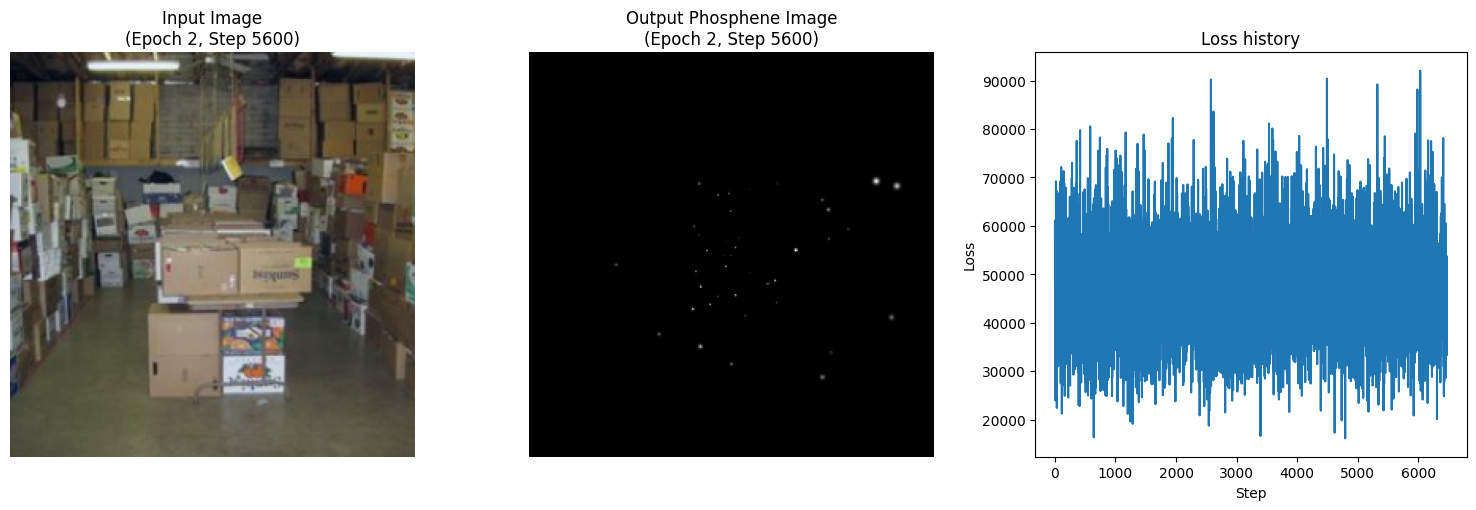

Epoch 2/5:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 5676/9290 [05:09<02:57, 20.31it/s, loss=59978.0938]

In [ ]:
torch.use_deterministic_algorithms(False)

# Instantiate your model, optimizer, and set number of epochs.
model = E2E_Encoder(in_channels=3, out_channels=1, n_electrodes=1024, out_scaling=amplitude, 
                     out_activation='relu', flattened_feature_size=1024*4).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0000001)
num_epochs = 5

losses = []

# Training loop using tqdm for elegant loss printing
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader), 
                     desc=f"Epoch {epoch+1}/{num_epochs}")
    try:
        for i, (images, _) in pbar:
            images = images.to(device).detach()
            stim = model(images).clamp(0, amplitude)
            
            simulator.reset()
            phosphenes = simulator(stim).unsqueeze(1)
            
            loss = content_loss_fn(images.mean(1, keepdim=True), phosphenes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            losses += [loss.item()]
            # Update tqdm postfix with the current loss value
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})
            
            # Visualize every 100 steps
            if i % 100 == 0:
                clear_output(wait=True)
                visualize_sample(images, phosphenes, epoch+1, i, losses)
    except:
        pass
    
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")